## Introduction to Theano

#### Symbolic Variables

In [7]:
import theano.tensor as T
import theano
from theano import function

In [8]:
x = T.scalar()


In [17]:
x
#print the type of x

<TensorType(float64, scalar)>

In [34]:
#Variables can be used in the expression for defining it
y = 3*(x-2)*3*4

In [35]:
type(y)#print the type of y

theano.tensor.var.TensorVariable

In [36]:
print y

Elemwise{mul,no_inplace}.0


In [37]:
theano.pprint(y)

'(((TensorConstant{3} * (<TensorType(float64, scalar)> - TensorConstant{2})) * TensorConstant{3}) * TensorConstant{4})'

In [38]:
theano.printing.debugprint(y)

Elemwise{mul,no_inplace} [id A] ''   
 |Elemwise{mul,no_inplace} [id B] ''   
 | |Elemwise{mul,no_inplace} [id C] ''   
 | | |TensorConstant{3} [id D]
 | | |Elemwise{sub,no_inplace} [id E] ''   
 | |   |<TensorType(float64, scalar)> [id F]
 | |   |TensorConstant{2} [id G]
 | |TensorConstant{3} [id D]
 |TensorConstant{4} [id H]


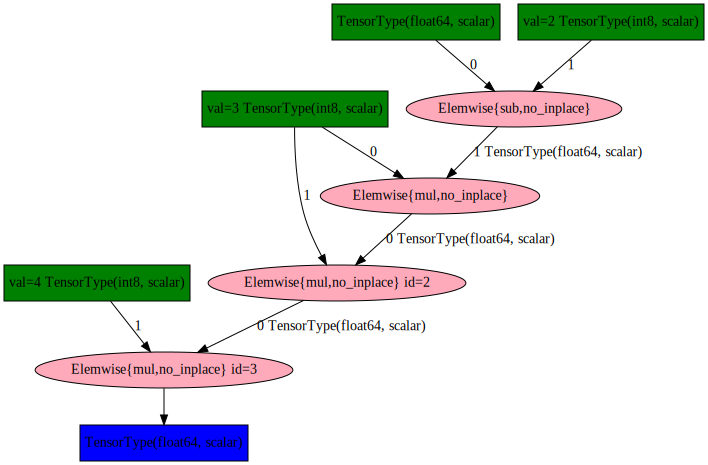

In [39]:
from IPython.display import SVG
SVG(theano.printing.pydotprint(y,return_image=True, format='svg'))

In [40]:
#evaluation Expression
print y.eval({x:5})

108.0


### Compiling a function

In [41]:
f = theano.function([x],y)

In [42]:
f(5)

array(108.0)

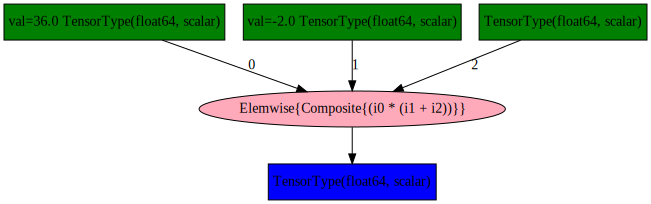

In [43]:
SVG(theano.printing.pydotprint(f,return_image=True,format='svg'))

In [45]:
#other types of tensor variable
temp = T.vector()
temp = T.matrix()
temp = T.tensor3()
temp = T.tensor4()

In [46]:
#Numyp Stype Indexing
x = T.vector()
x[1:-1:2]

Subtensor{int64:int64:int64}.0

In [47]:
#Automation Differention
#Gradients are free
x = T.scalar()
y = T.log(x)

In [49]:
gradient = T.grad(y,x)
gradient.eval({x:2})

array(0.5)

### Shared Variables


In [50]:
#Symbolic+storage

In [56]:
import numpy as np
x = theano.shared(np.zeros((2,3), dtype=theano.config.floatX))

In [57]:
x

<TensorType(float64, matrix)>

In [59]:
x.get_value()


array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [61]:
 another_value =np.ones((2,3))

In [63]:
x.set_value(another_value)

In [64]:
x.get_value()

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

### Shared Variables can be used in expressions as well

In [65]:
(x+2) **2


Elemwise{pow,no_inplace}.0

In [66]:
#Their value is used as input when evaluating

In [67]:
((x+2)**2).eval()

array([[ 9.,  9.,  9.],
       [ 9.,  9.,  9.]])

In [70]:
theano.function([],(x+2)**2)()


array([[ 9.,  9.,  9.],
       [ 9.,  9.,  9.]])

### Updates

Store results of function evaluation
dict mapping shared variables to new values

In [71]:
count = theano.shared(0)
new_count = count + 1

In [72]:
updates = {count:new_count}

In [73]:
f = theano.function([],count,updates = updates)

In [79]:
f()

array(5)

Make some exercises in logistics, fibonocci, and game of life

## Lasangne

Lasagne is a lightweight library to build and train neural networks in theano

1. Bookkeeping device
2. collection of helper functions

Design Goals
1. Simplicity, Transparency and Modularity
2. Abstract Theano as little as possible

LAYERS:
    Layer classe are the bulk of Lasagne
    1. Abstraction of a layer of neuron in a network
    2.But also used for other functions(Pooling, reshaping, etc..)
    3. Track Connectivity and data shape
    4. Create and manage parameters(weight)

OTHER MODEULE:
1. init - weight initialization algorithms
2. objectives - loss functions and evaluation metrics
3. regularization - penalty functions
4. updates - gradient descent variants

Defining Layer Sequences:
    input layer -> Layer(W,b) -> Layer(W,b)

Get Expression for output:
    


x -> Input Layer -> Layer (W,b) -> Layer(W,b) -> Output

Get Expression for loss function:

x -> Input Layer -> Layer (W,b) -> Layer(W,b) -> Output ->loss(D-Y)

### Sample code

In [81]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
import gzip
import pickle

In [87]:
np.random.seed(42)

In [88]:
train, val , test = pickle.load(gzip.open('mnist.pkl.gz'))

In [86]:
x_train, y_train =train
x_val, y_val = val

In [90]:
x_train.shape

(50000, 784)

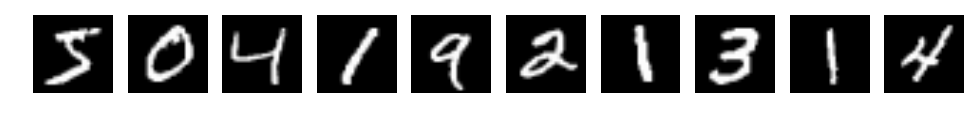

In [95]:
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i].reshape((28,28)),cmap='gray')
    plt.axis('off')

In [98]:
#for training we want to sample examples at random in small batches
def batch_gen(x,y,n):
    while True:
        idx = np.random.choice(len(y),n)
        yield x[idx].astype('float32'), y[idx].astype('int32')

In [99]:
#A very simple network, a single layer with one neuron per target class
#using the softmax activation functiongives us a probability distributing
l_in = lasagne.layers.InputLayer((None,784))
l_out = lasagne.layers.DenseLayer(
    l_in,
    num_units = 10,
    nonlinearity=lasagne.nonlinearities.softmax)

In [100]:
#symbolic variables for our input features and targets
x_sys = T.matrix()
y_sys = T.ivector()

In [102]:
#Theano Expression for the output distribution and predicted class
output = lasagne.layers.get_output(l_out, x_sys)
pred = output.argmax(-1)

In [104]:
#loss function is the cross-entropy averaged over a minibatch, we also computer accuracy
loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sys))
acc = T.mean(T.eq(pred,y_sys))


In [105]:
# we retrieve all the trainable_parameters in our network
params = lasagne.layers.get_all_params(l_out)
print params

[W, b]


In [107]:
#Compute the gradient of the loss function with respect to the parameters
#the stochastic Gradient Descent algorithm produces updates for each parameters
grad = T.grad(loss, params)
updates = lasagne.updates.sgd(grad,params,learning_rate = 0.05)
print updates

OrderedDict([(W, Elemwise{sub,no_inplace}.0), (b, Elemwise{sub,no_inplace}.0)])


In [108]:
#we define a training function that will compute the loss and accuracy
f_train = theano.function([x_sys,y_sys],[loss,acc],updates=updates)

In [109]:
f_val = theano.function([x_sys,y_sys],[loss,acc])


In [110]:
f_predict=theano.function([x_sys],pred)

In [117]:
#we will choose the bathc size, and calculate the number of batches in an input set
# (approximately one pass through the data)
BATCH_SIZE = 64
N_BATCHES = len(x_train) // BATCH_SIZE
N_VAL_BATCHES = len(x_val) // BATCH_SIZE

In [118]:
#Mininbatch generation for training and validation sets
train_batch = batch_gen(x_train, y_train, BATCH_SIZE)
val_batch = batch_gen(x_val, y_val, BATCH_SIZE)

9


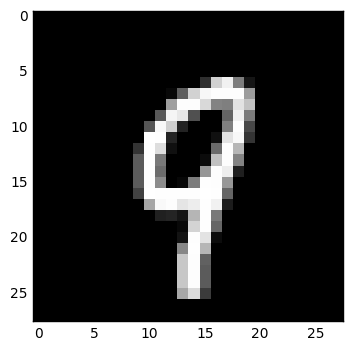

In [119]:
#try sampling from the batch generator
#plot an image and corresponding label to verify they match
x, y = next(train_batch)
plt.imshow(x[0].reshape((28,28)),cmap = 'gray',interpolation='nearest')
print y[0]

In [126]:
#for each epoch, we call the training function N_BATCHES times,
#accumulating an estimate of training loss and accuracy
#then we do the same thing for the validation set
#PLotting the ratio of val to train loss can help recognise the overfitting

for epoch in range(10):
    train_loss = 0 
    train_acc = 0
    for _ in range(N_BATCHES):
        x,y = next(train_batch)
        loss,acc = f_train(x,y)
        train_loss +=loss
        train_acc +=acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES
    val_loss = 0
    val_acc =0
    for _ in range(N_BATCHES):
        x,y = next(val_batch)
        loss,acc = f_val(x,y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_BATCHES
    val_acc /= N_BATCHES
    
    
    print ("Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}".format(epoch, train_loss,val_loss, val_loss/train_loss))
    print ("Train (val) accuracy {:.03f} ({:.03f})".format(train_acc,val_acc))

Epoch 0, Train (val) loss 0.282 (0.278) ratio 0.983
Train (val) accuracy 0.922 (0.922)
Epoch 1, Train (val) loss 0.290 (0.276) ratio 0.951
Train (val) accuracy 0.919 (0.923)
Epoch 2, Train (val) loss 0.281 (0.274) ratio 0.978
Train (val) accuracy 0.922 (0.924)
Epoch 3, Train (val) loss 0.286 (0.263) ratio 0.921
Train (val) accuracy 0.920 (0.925)
Epoch 4, Train (val) loss 0.282 (0.265) ratio 0.940
Train (val) accuracy 0.921 (0.927)
Epoch 5, Train (val) loss 0.274 (0.266) ratio 0.969
Train (val) accuracy 0.924 (0.924)
Epoch 6, Train (val) loss 0.276 (0.271) ratio 0.982
Train (val) accuracy 0.922 (0.924)
Epoch 7, Train (val) loss 0.280 (0.272) ratio 0.972
Train (val) accuracy 0.922 (0.924)
Epoch 8, Train (val) loss 0.276 (0.270) ratio 0.978
Train (val) accuracy 0.923 (0.924)
Epoch 9, Train (val) loss 0.274 (0.264) ratio 0.965
Train (val) accuracy 0.924 (0.927)


In [128]:
#we can retrieve the value of the trained weight matrix from the output
#it can be interpreted as a collection of images, one per class
weights = l_out.W.get_value()
print (weights.shape)

(784, 10)


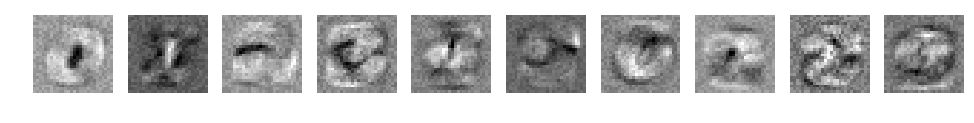

In [132]:
#plotting the weight images,we can recognise similarities to the target
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(weights[:,i].reshape((28,28)),cmap='gray',interpolation='nearest')
    plt.axis('off')

### Convolutional Digital Recognizer

In [133]:
import numpy as np
import theano
import theano.tensor as T 

In [134]:
#seed for reproduciblity
np.random.seed(42)